In [1]:
from datetime import datetime
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from tqdm import tqdm

from utils import (
    get_mesh_files,
    load_data,
    advect_nodes,
    remesh,
    optimize_mesh,
    compute_mapping,
    get_area_ratio,
    resample_velocities
)

np.seterr(divide='ignore', invalid='ignore')
%matplotlib inline

In [ ]:
mesh_init_file = r"D:\mesh_weddel_ease_25km_mmg_40_52.npz"
xc = np.load(mesh_init_file)['xc']
yc = np.load(mesh_init_file)['yc']
mask = np.load(mesh_init_file)['mask']
mask_f = gaussian_filter(mask.astype(float), 1, truncate=1)

In [3]:
force = False
min_edge_length = 26
max_edge_length = 76
min_edge_angle = 15
min_triangles = 5
search_dist = 100
max_dist0 = 100 #100 km? was 50 before 
min_area = 40
max_mask_fix_node=0.15
max_mask_zero_speed=0.6


sid_dir = r"D:\OSI-SAF\Preprocessing_Antarctica\2015"
lag_dir = r"D:\remeshing_Weddell"
ifiles = sorted(glob.glob(f'{sid_dir}/*npz'))

idates = [datetime.strptime(os.path.basename(ifile).split('-')[-1].split('.')[0], '%Y%m%d%H%M%S')
          for ifile in ifiles]
print(len(ifiles), idates[0], idates[-1])

365 2015-01-01 12:00:00 2015-12-31 12:00:00


In [4]:
# MOVE MESH
for ifile, idate in tqdm(zip(ifiles, idates), total=len(ifiles)):
    mesh_src_file, mesh_dst_file = get_mesh_files(idate, lag_dir, mesh_init_file)
    if os.path.exists(mesh_dst_file) and not force:
        continue
    u, v, tri0 = load_data(ifile, mesh_src_file)
    u0, v0, fixed_nodes_idx = resample_velocities(u, v, mask_f, xc, yc, tri0.x, tri0.y, max_mask_fix_node, max_mask_zero_speed)
    tri_a = advect_nodes(tri0, u0, v0, max_dist0)
    tri_r = remesh(tri_a, fixed_nodes_idx, min_area, min_edge_length, min_edge_angle, max_edge_length)
    tri_o = optimize_mesh(tri_a, tri_r, fixed_nodes_idx)
    src2dst, weights = compute_mapping(tri_a, tri_o, search_dist)
    area_ratio = get_area_ratio(tri0, tri_a, tri_o, src2dst, weights)

    print(f'Save mesh file to {mesh_dst_file}')
    np.savez(mesh_dst_file, x=tri_o.x, y=tri_o.y, t=tri_o.triangles, src2dst=src2dst, weights=weights, ar=area_ratio)

  0%|                                                                                          | 0/365 [00:00<?, ?it/s]

Load INIT


  0%|▏                                                                                 | 1/365 [00:02<18:03,  2.98s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150102.npz


  1%|▍                                                                                 | 2/365 [00:06<18:14,  3.02s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150103.npz


  1%|▋                                                                                 | 3/365 [00:09<19:01,  3.15s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150104.npz


  1%|▉                                                                                 | 4/365 [00:12<19:57,  3.32s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150105.npz


  1%|█                                                                                 | 5/365 [00:17<22:56,  3.82s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150106.npz


  2%|█▎                                                                                | 6/365 [00:20<21:46,  3.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150107.npz


  2%|█▌                                                                                | 7/365 [00:24<22:32,  3.78s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150108.npz


  2%|█▊                                                                                | 8/365 [00:28<22:53,  3.85s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150109.npz


  2%|██                                                                                | 9/365 [00:33<24:43,  4.17s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150110.npz


  3%|██▏                                                                              | 10/365 [00:38<26:18,  4.45s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150111.npz


  3%|██▍                                                                              | 11/365 [00:44<29:03,  4.92s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150112.npz


  3%|██▋                                                                              | 12/365 [00:51<31:17,  5.32s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150113.npz


  4%|██▉                                                                              | 13/365 [00:57<33:24,  5.69s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150114.npz


  4%|███                                                                              | 14/365 [01:03<33:32,  5.73s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150115.npz


  4%|███▎                                                                             | 15/365 [01:09<34:17,  5.88s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150116.npz


  4%|███▌                                                                             | 16/365 [01:17<37:42,  6.48s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150117.npz


  5%|███▊                                                                             | 17/365 [01:27<44:16,  7.63s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150118.npz


  5%|███▉                                                                             | 18/365 [01:36<46:25,  8.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150119.npz


  5%|████▏                                                                            | 19/365 [01:43<44:01,  7.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150120.npz


  5%|████▍                                                                            | 20/365 [01:50<42:32,  7.40s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150121.npz


  6%|████▋                                                                            | 21/365 [01:55<39:09,  6.83s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150122.npz


  6%|████▉                                                                            | 22/365 [02:04<42:21,  7.41s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150123.npz


  6%|█████                                                                            | 23/365 [02:11<41:25,  7.27s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150124.npz


  7%|█████▎                                                                           | 24/365 [02:16<37:59,  6.68s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150125.npz


  7%|█████▌                                                                           | 25/365 [02:25<41:43,  7.36s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150126.npz


  7%|█████▊                                                                           | 26/365 [02:30<36:28,  6.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150127.npz


  7%|█████▉                                                                           | 27/365 [02:34<32:58,  5.85s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150128.npz


  8%|██████▏                                                                          | 28/365 [02:39<30:21,  5.41s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150129.npz


  8%|██████▍                                                                          | 29/365 [02:44<29:51,  5.33s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150130.npz


  8%|██████▋                                                                          | 30/365 [02:48<28:48,  5.16s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150131.npz


  8%|██████▉                                                                          | 31/365 [02:54<29:13,  5.25s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150201.npz


  9%|███████                                                                          | 32/365 [02:58<26:55,  4.85s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150202.npz


  9%|███████▎                                                                         | 33/365 [03:02<26:08,  4.72s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150203.npz


  9%|███████▌                                                                         | 34/365 [03:08<27:27,  4.98s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150204.npz


 10%|███████▊                                                                         | 35/365 [03:13<27:27,  4.99s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150205.npz


 10%|███████▉                                                                         | 36/365 [03:19<28:59,  5.29s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150206.npz


 10%|████████▏                                                                        | 37/365 [03:24<29:21,  5.37s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150207.npz


 10%|████████▍                                                                        | 38/365 [03:31<30:51,  5.66s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150208.npz


 11%|████████▋                                                                        | 39/365 [03:36<29:28,  5.43s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150209.npz


 11%|████████▉                                                                        | 40/365 [03:43<32:56,  6.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150210.npz


 11%|█████████                                                                        | 41/365 [03:51<36:00,  6.67s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150211.npz


 12%|█████████▎                                                                       | 42/365 [03:56<33:25,  6.21s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150212.npz


 12%|█████████▌                                                                       | 43/365 [04:01<30:16,  5.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150213.npz


 12%|█████████▊                                                                       | 44/365 [04:05<27:23,  5.12s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150214.npz


 12%|█████████▉                                                                       | 45/365 [04:09<25:17,  4.74s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150215.npz


 13%|██████████▏                                                                      | 46/365 [04:14<26:02,  4.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150216.npz


 13%|██████████▍                                                                      | 47/365 [04:18<25:26,  4.80s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150217.npz


 13%|██████████▋                                                                      | 48/365 [04:23<24:24,  4.62s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150218.npz


 13%|██████████▊                                                                      | 49/365 [04:27<24:05,  4.57s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150219.npz


 14%|███████████                                                                      | 50/365 [04:31<23:35,  4.49s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150220.npz


 14%|███████████▎                                                                     | 51/365 [04:35<22:57,  4.39s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150221.npz


 14%|███████████▌                                                                     | 52/365 [04:39<21:33,  4.13s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150222.npz


 15%|███████████▊                                                                     | 53/365 [04:44<23:09,  4.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150223.npz


 15%|███████████▉                                                                     | 54/365 [04:52<27:48,  5.37s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150224.npz


 15%|████████████▏                                                                    | 55/365 [04:58<28:29,  5.52s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150225.npz


 15%|████████████▍                                                                    | 56/365 [05:03<28:24,  5.52s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150226.npz


 16%|████████████▋                                                                    | 57/365 [05:09<28:30,  5.55s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150227.npz


 16%|████████████▊                                                                    | 58/365 [05:15<29:40,  5.80s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150228.npz


 16%|█████████████                                                                    | 59/365 [05:22<31:30,  6.18s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150301.npz


 16%|█████████████▎                                                                   | 60/365 [05:30<33:11,  6.53s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150302.npz


 17%|█████████████▌                                                                   | 61/365 [05:36<33:25,  6.60s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150303.npz


 17%|█████████████▊                                                                   | 62/365 [05:42<31:35,  6.26s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150304.npz


 17%|█████████████▉                                                                   | 63/365 [05:46<28:23,  5.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150305.npz


 18%|██████████████▏                                                                  | 64/365 [05:51<27:54,  5.56s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150306.npz


 18%|██████████████▍                                                                  | 65/365 [05:57<27:41,  5.54s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150307.npz


 18%|██████████████▋                                                                  | 66/365 [06:03<28:43,  5.77s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150308.npz


 18%|██████████████▊                                                                  | 67/365 [06:09<29:28,  5.93s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150309.npz


 19%|███████████████                                                                  | 68/365 [06:14<26:48,  5.42s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150310.npz


 19%|███████████████▎                                                                 | 69/365 [06:18<25:09,  5.10s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150311.npz


 19%|███████████████▌                                                                 | 70/365 [06:22<23:39,  4.81s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150312.npz


 19%|███████████████▊                                                                 | 71/365 [06:26<21:52,  4.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150313.npz


 20%|███████████████▉                                                                 | 72/365 [06:30<21:54,  4.49s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150314.npz


 20%|████████████████▏                                                                | 73/365 [06:35<22:05,  4.54s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150315.npz


 20%|████████████████▍                                                                | 74/365 [06:40<23:23,  4.82s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150316.npz


 21%|████████████████▋                                                                | 75/365 [06:46<23:38,  4.89s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150317.npz


 21%|████████████████▊                                                                | 76/365 [06:51<24:35,  5.11s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150318.npz


 21%|█████████████████                                                                | 77/365 [06:58<26:39,  5.55s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150319.npz


 21%|█████████████████▎                                                               | 78/365 [07:04<27:32,  5.76s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150320.npz


 22%|█████████████████▌                                                               | 79/365 [07:11<29:16,  6.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150321.npz


 22%|█████████████████▊                                                               | 80/365 [07:18<30:13,  6.36s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150322.npz


 22%|█████████████████▉                                                               | 81/365 [07:25<30:36,  6.47s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150323.npz


 22%|██████████████████▏                                                              | 82/365 [07:33<32:47,  6.95s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150324.npz


 23%|██████████████████▍                                                              | 83/365 [07:38<30:41,  6.53s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150325.npz


 23%|██████████████████▋                                                              | 84/365 [07:46<32:45,  7.00s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150326.npz


 23%|██████████████████▊                                                              | 85/365 [07:53<32:42,  7.01s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150327.npz


 24%|███████████████████                                                              | 86/365 [08:00<31:36,  6.80s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150328.npz


 24%|███████████████████▎                                                             | 87/365 [08:06<30:52,  6.66s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150329.npz


 24%|███████████████████▌                                                             | 88/365 [08:13<31:44,  6.87s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150330.npz


 24%|███████████████████▊                                                             | 89/365 [08:19<29:31,  6.42s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150331.npz


 25%|███████████████████▉                                                             | 90/365 [08:25<29:24,  6.41s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150401.npz


 25%|████████████████████▏                                                            | 91/365 [08:33<31:40,  6.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150402.npz


 25%|████████████████████▍                                                            | 92/365 [08:39<30:28,  6.70s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150403.npz


 25%|████████████████████▋                                                            | 93/365 [08:47<31:58,  7.05s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150404.npz


 26%|████████████████████▊                                                            | 94/365 [08:55<33:20,  7.38s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150405.npz


 26%|█████████████████████                                                            | 95/365 [09:05<36:04,  8.02s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150406.npz


 26%|█████████████████████▎                                                           | 96/365 [09:12<35:07,  7.83s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150407.npz


 27%|█████████████████████▌                                                           | 97/365 [09:19<33:35,  7.52s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150408.npz


 27%|█████████████████████▋                                                           | 98/365 [09:26<33:05,  7.44s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150409.npz


 27%|█████████████████████▉                                                           | 99/365 [09:33<32:22,  7.30s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150410.npz


 27%|█████████████████████▉                                                          | 100/365 [09:42<34:07,  7.73s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150411.npz


 28%|██████████████████████▏                                                         | 101/365 [09:51<34:55,  7.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150412.npz


 28%|██████████████████████▎                                                         | 102/365 [09:59<36:05,  8.23s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150413.npz


 28%|██████████████████████▌                                                         | 103/365 [10:09<38:05,  8.72s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150414.npz


 28%|██████████████████████▊                                                         | 104/365 [10:16<35:31,  8.17s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150415.npz


 29%|███████████████████████                                                         | 105/365 [10:27<38:35,  8.91s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150416.npz


 29%|███████████████████████▏                                                        | 106/365 [10:36<38:36,  8.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150417.npz


 29%|███████████████████████▍                                                        | 107/365 [10:43<35:45,  8.32s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150418.npz


 30%|███████████████████████▋                                                        | 108/365 [10:48<31:52,  7.44s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150419.npz


 30%|███████████████████████▉                                                        | 109/365 [10:54<29:23,  6.89s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150420.npz


 30%|████████████████████████                                                        | 110/365 [10:59<27:47,  6.54s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150421.npz


 30%|████████████████████████▎                                                       | 111/365 [11:06<27:21,  6.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150422.npz


 31%|████████████████████████▌                                                       | 112/365 [11:12<26:28,  6.28s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150423.npz


 31%|████████████████████████▊                                                       | 113/365 [11:17<24:46,  5.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150424.npz


 31%|████████████████████████▉                                                       | 114/365 [11:25<27:58,  6.69s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150425.npz


 32%|█████████████████████████▏                                                      | 115/365 [11:35<32:03,  7.70s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150426.npz


 32%|█████████████████████████▍                                                      | 116/365 [11:44<33:15,  8.01s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150427.npz


 32%|█████████████████████████▋                                                      | 117/365 [11:52<33:20,  8.07s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150428.npz


 32%|█████████████████████████▊                                                      | 118/365 [12:00<32:59,  8.02s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150429.npz


 33%|██████████████████████████                                                      | 119/365 [12:08<33:18,  8.12s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150430.npz


 33%|██████████████████████████▎                                                     | 120/365 [12:16<32:00,  7.84s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150501.npz


 33%|██████████████████████████▌                                                     | 121/365 [12:24<32:56,  8.10s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150502.npz


 33%|██████████████████████████▋                                                     | 122/365 [12:32<31:55,  7.88s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150503.npz


 34%|██████████████████████████▉                                                     | 123/365 [12:38<29:31,  7.32s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150504.npz


 34%|███████████████████████████▏                                                    | 124/365 [12:45<29:12,  7.27s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150505.npz


 34%|███████████████████████████▍                                                    | 125/365 [12:52<28:37,  7.16s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150506.npz


 35%|███████████████████████████▌                                                    | 126/365 [12:59<28:49,  7.24s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150507.npz


 35%|███████████████████████████▊                                                    | 127/365 [13:08<30:38,  7.73s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150508.npz


 35%|████████████████████████████                                                    | 128/365 [13:15<29:38,  7.50s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150509.npz


 35%|████████████████████████████▎                                                   | 129/365 [13:22<28:55,  7.35s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150510.npz


 36%|████████████████████████████▍                                                   | 130/365 [13:29<28:58,  7.40s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150511.npz


 36%|████████████████████████████▋                                                   | 131/365 [13:38<29:45,  7.63s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150512.npz


 36%|████████████████████████████▉                                                   | 132/365 [13:49<34:29,  8.88s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150513.npz


 36%|█████████████████████████████▏                                                  | 133/365 [13:59<35:00,  9.05s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150514.npz


 37%|█████████████████████████████▎                                                  | 134/365 [14:08<34:32,  8.97s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150515.npz


 37%|█████████████████████████████▌                                                  | 135/365 [14:15<32:42,  8.53s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150516.npz


 37%|█████████████████████████████▊                                                  | 136/365 [14:24<32:36,  8.55s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150517.npz


 38%|██████████████████████████████                                                  | 137/365 [14:34<34:19,  9.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150518.npz
Fixed by negative area factor 0.25 100 16


 38%|██████████████████████████████▏                                                 | 138/365 [14:45<36:33,  9.66s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150519.npz


 38%|██████████████████████████████▍                                                 | 139/365 [14:56<37:29,  9.95s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150520.npz


 38%|██████████████████████████████▋                                                 | 140/365 [15:09<40:37, 10.83s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150521.npz


 39%|██████████████████████████████▉                                                 | 141/365 [15:19<40:13, 10.77s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150522.npz


 39%|███████████████████████████████                                                 | 142/365 [15:31<41:42, 11.22s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150523.npz


 39%|███████████████████████████████▎                                                | 143/365 [15:40<38:23, 10.38s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150524.npz


 39%|███████████████████████████████▌                                                | 144/365 [15:46<34:04,  9.25s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150525.npz


 40%|███████████████████████████████▊                                                | 145/365 [15:54<31:46,  8.67s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150526.npz


 40%|████████████████████████████████                                                | 146/365 [16:01<30:08,  8.26s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150527.npz


 40%|████████████████████████████████▏                                               | 147/365 [16:08<28:03,  7.72s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150528.npz


 41%|████████████████████████████████▍                                               | 148/365 [16:18<30:37,  8.47s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150529.npz


 41%|████████████████████████████████▋                                               | 149/365 [16:28<32:32,  9.04s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150530.npz


 41%|████████████████████████████████▉                                               | 150/365 [16:40<35:09,  9.81s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150531.npz


 41%|█████████████████████████████████                                               | 151/365 [16:57<43:05, 12.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150601.npz


 42%|█████████████████████████████████▎                                              | 152/365 [17:09<42:54, 12.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150602.npz


 42%|█████████████████████████████████▌                                              | 153/365 [17:26<47:21, 13.41s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150603.npz


 42%|█████████████████████████████████▊                                              | 154/365 [17:39<47:23, 13.48s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150604.npz


 42%|█████████████████████████████████▉                                              | 155/365 [17:49<42:50, 12.24s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150605.npz


 43%|██████████████████████████████████▏                                             | 156/365 [17:56<36:56, 10.61s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150606.npz


 43%|██████████████████████████████████▍                                             | 157/365 [18:03<33:45,  9.74s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150607.npz


 43%|██████████████████████████████████▋                                             | 158/365 [18:10<30:59,  8.98s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150608.npz


 44%|██████████████████████████████████▊                                             | 159/365 [18:16<27:25,  7.99s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150609.npz


 44%|███████████████████████████████████                                             | 160/365 [18:23<25:42,  7.52s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150610.npz


 44%|███████████████████████████████████▎                                            | 161/365 [18:30<25:25,  7.48s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150611.npz


 44%|███████████████████████████████████▌                                            | 162/365 [18:39<26:46,  7.91s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150612.npz


 45%|███████████████████████████████████▋                                            | 163/365 [18:47<26:24,  7.84s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150613.npz


 45%|███████████████████████████████████▉                                            | 164/365 [18:55<26:53,  8.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150614.npz


 45%|████████████████████████████████████▏                                           | 165/365 [19:02<26:08,  7.84s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150615.npz


 45%|████████████████████████████████████▍                                           | 166/365 [19:13<28:38,  8.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150616.npz


 46%|████████████████████████████████████▌                                           | 167/365 [19:22<28:56,  8.77s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150617.npz


 46%|████████████████████████████████████▊                                           | 168/365 [19:32<30:10,  9.19s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150618.npz


 46%|█████████████████████████████████████                                           | 169/365 [19:42<30:53,  9.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150619.npz


 47%|█████████████████████████████████████▎                                          | 170/365 [19:50<29:35,  9.11s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150620.npz


 47%|█████████████████████████████████████▍                                          | 171/365 [19:59<28:34,  8.84s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150621.npz


 47%|█████████████████████████████████████▋                                          | 172/365 [20:09<29:23,  9.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150622.npz


 47%|█████████████████████████████████████▉                                          | 173/365 [20:26<36:55, 11.54s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150623.npz


 48%|██████████████████████████████████████▏                                         | 174/365 [20:36<35:52, 11.27s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150624.npz


 48%|██████████████████████████████████████▎                                         | 175/365 [20:46<34:31, 10.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150625.npz


 48%|██████████████████████████████████████▌                                         | 176/365 [20:56<33:03, 10.50s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150626.npz


 48%|██████████████████████████████████████▊                                         | 177/365 [21:08<33:59, 10.85s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150627.npz


 49%|███████████████████████████████████████                                         | 178/365 [21:18<33:38, 10.79s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150628.npz


 49%|███████████████████████████████████████▏                                        | 179/365 [21:30<34:36, 11.16s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150629.npz


 49%|███████████████████████████████████████▍                                        | 180/365 [21:41<34:14, 11.11s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150630.npz


 50%|███████████████████████████████████████▋                                        | 181/365 [21:53<34:54, 11.38s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150701.npz


 50%|███████████████████████████████████████▉                                        | 182/365 [22:06<36:17, 11.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150702.npz


 50%|████████████████████████████████████████                                        | 183/365 [22:20<38:00, 12.53s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150703.npz


 50%|████████████████████████████████████████▎                                       | 184/365 [22:36<40:28, 13.42s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150704.npz


 51%|████████████████████████████████████████▌                                       | 185/365 [22:53<43:14, 14.42s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150705.npz


 51%|████████████████████████████████████████▊                                       | 186/365 [23:08<44:04, 14.77s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150706.npz


 51%|████████████████████████████████████████▉                                       | 187/365 [23:22<43:02, 14.51s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150707.npz


 52%|█████████████████████████████████████████▏                                      | 188/365 [23:36<42:19, 14.35s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150708.npz
Fixed by negative area factor 0.25 100 47


 52%|█████████████████████████████████████████▍                                      | 189/365 [23:51<42:34, 14.51s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150709.npz
Fixed by negative area factor 0.5 200 124


 52%|█████████████████████████████████████████▋                                      | 190/365 [24:02<39:04, 13.40s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150710.npz


 52%|█████████████████████████████████████████▊                                      | 191/365 [24:11<35:25, 12.21s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150711.npz


 53%|██████████████████████████████████████████                                      | 192/365 [24:23<34:41, 12.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150712.npz


 53%|██████████████████████████████████████████▎                                     | 193/365 [24:36<35:06, 12.25s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150713.npz


 53%|██████████████████████████████████████████▌                                     | 194/365 [24:49<35:57, 12.61s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150714.npz


 53%|██████████████████████████████████████████▋                                     | 195/365 [25:03<37:06, 13.10s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150715.npz


 54%|██████████████████████████████████████████▉                                     | 196/365 [25:24<43:39, 15.50s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150716.npz


 54%|███████████████████████████████████████████▏                                    | 197/365 [25:43<45:44, 16.34s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150717.npz


 54%|███████████████████████████████████████████▍                                    | 198/365 [25:57<43:56, 15.79s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150718.npz


 55%|███████████████████████████████████████████▌                                    | 199/365 [26:13<43:30, 15.73s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150719.npz


 55%|███████████████████████████████████████████▊                                    | 200/365 [26:26<41:20, 15.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150720.npz


 55%|████████████████████████████████████████████                                    | 201/365 [26:40<40:03, 14.66s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150721.npz


 55%|████████████████████████████████████████████▎                                   | 202/365 [26:53<38:24, 14.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150722.npz
Fixed by negative area factor 0.5 200 114


 56%|████████████████████████████████████████████▍                                   | 203/365 [27:07<38:17, 14.18s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150723.npz
Fixed by negative area factor 0.5 100 19


 56%|████████████████████████████████████████████▋                                   | 204/365 [27:21<37:46, 14.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150724.npz


 56%|████████████████████████████████████████████▉                                   | 205/365 [27:37<39:02, 14.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150725.npz


 56%|█████████████████████████████████████████████▏                                  | 206/365 [27:49<36:43, 13.86s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150726.npz


 57%|█████████████████████████████████████████████▎                                  | 207/365 [28:01<35:08, 13.35s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150727.npz


 57%|█████████████████████████████████████████████▌                                  | 208/365 [28:14<34:23, 13.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150728.npz


 57%|█████████████████████████████████████████████▊                                  | 209/365 [28:25<32:51, 12.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150729.npz


 58%|██████████████████████████████████████████████                                  | 210/365 [28:37<31:42, 12.28s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150730.npz
Fixed by negative area factor 0.25 100 47


 58%|██████████████████████████████████████████████▏                                 | 211/365 [28:48<30:24, 11.85s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150731.npz


 58%|██████████████████████████████████████████████▍                                 | 212/365 [28:57<28:18, 11.10s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150801.npz


 58%|██████████████████████████████████████████████▋                                 | 213/365 [29:07<27:41, 10.93s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150802.npz
Fixed by negative area factor 0.25 100 58


 59%|██████████████████████████████████████████████▉                                 | 214/365 [29:17<26:47, 10.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150803.npz
Fixed by negative area factor 0.5 200 86


 59%|███████████████████████████████████████████████                                 | 215/365 [29:31<28:35, 11.44s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150804.npz


 59%|███████████████████████████████████████████████▎                                | 216/365 [29:41<27:30, 11.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150805.npz


 59%|███████████████████████████████████████████████▌                                | 217/365 [29:50<25:42, 10.42s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150806.npz


 60%|███████████████████████████████████████████████▊                                | 218/365 [29:58<23:47,  9.71s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150807.npz


 60%|████████████████████████████████████████████████                                | 219/365 [30:08<24:05,  9.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150808.npz


 60%|████████████████████████████████████████████████▏                               | 220/365 [30:17<23:25,  9.70s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150809.npz
Fixed by negative area factor 0.5 100 23


 61%|████████████████████████████████████████████████▍                               | 221/365 [30:30<25:06, 10.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150810.npz
Fixed by negative area factor 0.5 200 186


 61%|████████████████████████████████████████████████▋                               | 222/365 [30:45<28:36, 12.00s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150811.npz
Fixed by negative area factor 0.25 100 19


 61%|████████████████████████████████████████████████▉                               | 223/365 [30:58<28:38, 12.10s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150812.npz


 61%|█████████████████████████████████████████████████                               | 224/365 [31:12<29:41, 12.64s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150813.npz
Fixed by negative area factor 0.5 200 76


 62%|█████████████████████████████████████████████████▎                              | 225/365 [31:26<30:34, 13.11s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150814.npz


 62%|█████████████████████████████████████████████████▌                              | 226/365 [31:40<31:07, 13.43s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150815.npz


 62%|█████████████████████████████████████████████████▊                              | 227/365 [31:53<30:22, 13.20s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150816.npz


 62%|█████████████████████████████████████████████████▉                              | 228/365 [32:06<29:58, 13.13s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150817.npz


 63%|██████████████████████████████████████████████████▏                             | 229/365 [32:19<29:41, 13.10s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150818.npz


 63%|██████████████████████████████████████████████████▍                             | 230/365 [32:35<31:24, 13.96s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150819.npz


 63%|██████████████████████████████████████████████████▋                             | 231/365 [32:50<32:22, 14.50s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150820.npz


 64%|██████████████████████████████████████████████████▊                             | 232/365 [33:06<33:00, 14.89s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150821.npz
Fixed by negative area factor 0.5 100 19


 64%|███████████████████████████████████████████████████                             | 233/365 [33:22<33:18, 15.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150822.npz
Fixed by negative area factor 0.5 100 19


 64%|███████████████████████████████████████████████████▎                            | 234/365 [33:37<33:05, 15.16s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150823.npz
Fixed by negative area factor 0.75 100 37


 64%|███████████████████████████████████████████████████▌                            | 235/365 [33:54<34:02, 15.71s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150824.npz


 65%|███████████████████████████████████████████████████▋                            | 236/365 [34:06<31:36, 14.70s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150825.npz


 65%|███████████████████████████████████████████████████▉                            | 237/365 [34:17<28:40, 13.44s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150826.npz


 65%|████████████████████████████████████████████████████▏                           | 238/365 [34:27<26:28, 12.50s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150827.npz


 65%|████████████████████████████████████████████████████▍                           | 239/365 [34:38<25:05, 11.95s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150828.npz


 66%|████████████████████████████████████████████████████▌                           | 240/365 [34:48<23:29, 11.27s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150829.npz


 66%|████████████████████████████████████████████████████▊                           | 241/365 [34:58<23:01, 11.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150830.npz


 66%|█████████████████████████████████████████████████████                           | 242/365 [35:09<22:26, 10.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150831.npz
Fixed by negative area factor 0.25 100 23


 67%|█████████████████████████████████████████████████████▎                          | 243/365 [35:18<21:16, 10.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150901.npz
Fixed by negative area factor 0.25 100 23


 67%|█████████████████████████████████████████████████████▍                          | 244/365 [35:28<20:58, 10.40s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150902.npz


 67%|█████████████████████████████████████████████████████▋                          | 245/365 [35:38<20:25, 10.21s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150903.npz


 67%|█████████████████████████████████████████████████████▉                          | 246/365 [35:47<19:24,  9.79s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150904.npz


 68%|██████████████████████████████████████████████████████▏                         | 247/365 [35:57<19:06,  9.72s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150905.npz


 68%|██████████████████████████████████████████████████████▎                         | 248/365 [36:07<19:22,  9.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150906.npz


 68%|██████████████████████████████████████████████████████▌                         | 249/365 [36:20<20:42, 10.71s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150907.npz


 68%|██████████████████████████████████████████████████████▊                         | 250/365 [36:32<21:21, 11.14s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150908.npz


 69%|███████████████████████████████████████████████████████                         | 251/365 [36:44<21:45, 11.45s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150909.npz


 69%|███████████████████████████████████████████████████████▏                        | 252/365 [36:56<21:50, 11.60s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150910.npz


 69%|███████████████████████████████████████████████████████▍                        | 253/365 [37:09<22:20, 11.97s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150911.npz


 70%|███████████████████████████████████████████████████████▋                        | 254/365 [37:22<23:03, 12.46s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150912.npz
Fixed by negative area factor 0.25 100 18


 70%|███████████████████████████████████████████████████████▉                        | 255/365 [37:35<23:16, 12.69s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150913.npz
Fixed by negative area factor 0.5 200 174


 70%|████████████████████████████████████████████████████████                        | 256/365 [37:45<21:28, 11.82s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150914.npz
Fixed by negative area factor 0.5 200 125


 70%|████████████████████████████████████████████████████████▎                       | 257/365 [37:55<20:04, 11.15s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150915.npz


 71%|████████████████████████████████████████████████████████▌                       | 258/365 [38:07<20:11, 11.32s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150916.npz


 71%|████████████████████████████████████████████████████████▊                       | 259/365 [38:18<20:13, 11.45s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150917.npz
Fixed by negative area factor 0.25 100 30


 71%|████████████████████████████████████████████████████████▉                       | 260/365 [38:32<21:02, 12.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150918.npz


 72%|█████████████████████████████████████████████████████████▏                      | 261/365 [38:44<21:09, 12.21s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150919.npz


 72%|█████████████████████████████████████████████████████████▍                      | 262/365 [38:55<20:16, 11.81s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150920.npz


 72%|█████████████████████████████████████████████████████████▋                      | 263/365 [39:08<20:36, 12.12s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150921.npz


 72%|█████████████████████████████████████████████████████████▊                      | 264/365 [39:20<20:21, 12.09s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150922.npz


 73%|██████████████████████████████████████████████████████████                      | 265/365 [39:33<20:46, 12.47s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150923.npz


 73%|██████████████████████████████████████████████████████████▎                     | 266/365 [39:45<20:00, 12.12s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150924.npz


 73%|██████████████████████████████████████████████████████████▌                     | 267/365 [39:57<19:38, 12.02s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150925.npz


 73%|██████████████████████████████████████████████████████████▋                     | 268/365 [40:09<19:31, 12.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150926.npz


 74%|██████████████████████████████████████████████████████████▉                     | 269/365 [40:23<20:25, 12.76s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150927.npz


 74%|███████████████████████████████████████████████████████████▏                    | 270/365 [40:37<20:53, 13.20s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150928.npz


 74%|███████████████████████████████████████████████████████████▍                    | 271/365 [40:51<20:46, 13.26s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150929.npz


 75%|███████████████████████████████████████████████████████████▌                    | 272/365 [41:04<20:26, 13.19s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20150930.npz


 75%|███████████████████████████████████████████████████████████▊                    | 273/365 [41:16<19:56, 13.00s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151001.npz


 75%|████████████████████████████████████████████████████████████                    | 274/365 [41:30<19:57, 13.16s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151002.npz


 75%|████████████████████████████████████████████████████████████▎                   | 275/365 [41:45<20:25, 13.61s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151003.npz
Fixed by negative area factor 0.25 100 19


 76%|████████████████████████████████████████████████████████████▍                   | 276/365 [41:59<20:39, 13.92s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151004.npz


 76%|████████████████████████████████████████████████████████████▋                   | 277/365 [42:12<20:05, 13.69s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151005.npz


 76%|████████████████████████████████████████████████████████████▉                   | 278/365 [42:24<18:57, 13.07s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151006.npz


 76%|█████████████████████████████████████████████████████████████▏                  | 279/365 [42:35<18:02, 12.59s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151007.npz


 77%|█████████████████████████████████████████████████████████████▎                  | 280/365 [42:47<17:15, 12.19s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151008.npz


 77%|█████████████████████████████████████████████████████████████▌                  | 281/365 [43:00<17:36, 12.58s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151009.npz


 77%|█████████████████████████████████████████████████████████████▊                  | 282/365 [43:13<17:23, 12.57s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151010.npz


 78%|██████████████████████████████████████████████████████████████                  | 283/365 [43:26<17:19, 12.68s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151011.npz


 78%|██████████████████████████████████████████████████████████████▏                 | 284/365 [43:39<17:30, 12.97s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151012.npz


 78%|██████████████████████████████████████████████████████████████▍                 | 285/365 [43:55<18:19, 13.75s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151013.npz


 78%|██████████████████████████████████████████████████████████████▋                 | 286/365 [44:09<18:05, 13.74s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151014.npz


 79%|██████████████████████████████████████████████████████████████▉                 | 287/365 [44:21<17:21, 13.35s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151015.npz


 79%|███████████████████████████████████████████████████████████████                 | 288/365 [44:33<16:43, 13.04s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151016.npz


 79%|███████████████████████████████████████████████████████████████▎                | 289/365 [44:45<15:58, 12.61s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151017.npz


 79%|███████████████████████████████████████████████████████████████▌                | 290/365 [44:55<14:53, 11.92s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151018.npz


 80%|███████████████████████████████████████████████████████████████▊                | 291/365 [45:08<15:05, 12.24s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151019.npz


 80%|████████████████████████████████████████████████████████████████                | 292/365 [45:21<15:14, 12.52s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151020.npz


 80%|████████████████████████████████████████████████████████████████▏               | 293/365 [45:36<15:48, 13.17s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151021.npz


 81%|████████████████████████████████████████████████████████████████▍               | 294/365 [45:48<15:18, 12.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151022.npz


 81%|████████████████████████████████████████████████████████████████▋               | 295/365 [46:01<15:02, 12.89s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151023.npz


 81%|████████████████████████████████████████████████████████████████▉               | 296/365 [46:13<14:30, 12.62s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151024.npz


 81%|█████████████████████████████████████████████████████████████████               | 297/365 [46:25<13:58, 12.33s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151025.npz


 82%|█████████████████████████████████████████████████████████████████▎              | 298/365 [46:36<13:29, 12.09s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151026.npz
Fixed by negative area factor 0.5 100 15


 82%|█████████████████████████████████████████████████████████████████▌              | 299/365 [46:47<12:44, 11.58s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151027.npz


 82%|█████████████████████████████████████████████████████████████████▊              | 300/365 [46:57<12:07, 11.19s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151028.npz


 82%|█████████████████████████████████████████████████████████████████▉              | 301/365 [47:05<10:55, 10.25s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151029.npz


 83%|██████████████████████████████████████████████████████████████████▏             | 302/365 [47:15<10:42, 10.20s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151030.npz


 83%|██████████████████████████████████████████████████████████████████▍             | 303/365 [47:27<11:03, 10.71s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151031.npz
Fixed by negative area factor 0.25 100 31


 83%|██████████████████████████████████████████████████████████████████▋             | 304/365 [47:42<12:06, 11.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151101.npz


 84%|██████████████████████████████████████████████████████████████████▊             | 305/365 [47:57<12:56, 12.93s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151102.npz


 84%|███████████████████████████████████████████████████████████████████             | 306/365 [48:10<12:41, 12.91s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151103.npz


 84%|███████████████████████████████████████████████████████████████████▎            | 307/365 [48:21<11:51, 12.27s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151104.npz


 84%|███████████████████████████████████████████████████████████████████▌            | 308/365 [48:33<11:30, 12.11s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151105.npz


 85%|███████████████████████████████████████████████████████████████████▋            | 309/365 [48:44<11:06, 11.90s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151106.npz


 85%|███████████████████████████████████████████████████████████████████▉            | 310/365 [48:55<10:43, 11.69s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151107.npz


 85%|████████████████████████████████████████████████████████████████████▏           | 311/365 [49:06<10:25, 11.59s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151108.npz


 85%|████████████████████████████████████████████████████████████████████▍           | 312/365 [49:18<10:14, 11.60s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151109.npz


 86%|████████████████████████████████████████████████████████████████████▌           | 313/365 [49:30<10:03, 11.60s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151110.npz


 86%|████████████████████████████████████████████████████████████████████▊           | 314/365 [49:41<09:51, 11.60s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151111.npz


 86%|█████████████████████████████████████████████████████████████████████           | 315/365 [49:53<09:40, 11.61s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151112.npz


 87%|█████████████████████████████████████████████████████████████████████▎          | 316/365 [50:04<09:22, 11.48s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151113.npz


 87%|█████████████████████████████████████████████████████████████████████▍          | 317/365 [50:17<09:28, 11.84s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151114.npz


 87%|█████████████████████████████████████████████████████████████████████▋          | 318/365 [50:29<09:20, 11.94s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151115.npz


 87%|█████████████████████████████████████████████████████████████████████▉          | 319/365 [50:44<09:48, 12.80s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151116.npz


 88%|██████████████████████████████████████████████████████████████████████▏         | 320/365 [50:58<10:00, 13.35s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151117.npz


 88%|██████████████████████████████████████████████████████████████████████▎         | 321/365 [51:14<10:10, 13.88s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151118.npz


 88%|██████████████████████████████████████████████████████████████████████▌         | 322/365 [51:27<09:45, 13.61s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151119.npz


 88%|██████████████████████████████████████████████████████████████████████▊         | 323/365 [51:39<09:20, 13.35s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151120.npz


 89%|███████████████████████████████████████████████████████████████████████         | 324/365 [51:50<08:37, 12.62s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151121.npz


 89%|███████████████████████████████████████████████████████████████████████▏        | 325/365 [52:00<07:55, 11.88s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151122.npz


 89%|███████████████████████████████████████████████████████████████████████▍        | 326/365 [52:10<07:15, 11.17s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151123.npz


 90%|███████████████████████████████████████████████████████████████████████▋        | 327/365 [52:19<06:40, 10.55s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151124.npz


 90%|███████████████████████████████████████████████████████████████████████▉        | 328/365 [52:29<06:20, 10.28s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151125.npz


 90%|████████████████████████████████████████████████████████████████████████        | 329/365 [52:38<06:04, 10.13s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151126.npz


 90%|████████████████████████████████████████████████████████████████████████▎       | 330/365 [52:49<05:59, 10.26s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151127.npz


 91%|████████████████████████████████████████████████████████████████████████▌       | 331/365 [53:00<05:54, 10.41s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151128.npz


 91%|████████████████████████████████████████████████████████████████████████▊       | 332/365 [53:11<05:52, 10.68s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151129.npz
Fixed by negative area factor 0.25 100 20


 91%|████████████████████████████████████████████████████████████████████████▉       | 333/365 [53:22<05:42, 10.69s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151130.npz


 92%|█████████████████████████████████████████████████████████████████████████▏      | 334/365 [53:37<06:16, 12.15s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151201.npz


 92%|█████████████████████████████████████████████████████████████████████████▍      | 335/365 [53:54<06:41, 13.38s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151202.npz


 92%|█████████████████████████████████████████████████████████████████████████▋      | 336/365 [54:05<06:15, 12.93s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151203.npz


 92%|█████████████████████████████████████████████████████████████████████████▊      | 337/365 [54:16<05:42, 12.24s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151204.npz


 93%|██████████████████████████████████████████████████████████████████████████      | 338/365 [54:29<05:34, 12.39s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151205.npz


 93%|██████████████████████████████████████████████████████████████████████████▎     | 339/365 [54:42<05:26, 12.54s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151206.npz


 93%|██████████████████████████████████████████████████████████████████████████▌     | 340/365 [54:53<05:07, 12.29s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151207.npz


 93%|██████████████████████████████████████████████████████████████████████████▋     | 341/365 [55:09<05:19, 13.31s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151208.npz


 94%|██████████████████████████████████████████████████████████████████████████▉     | 342/365 [55:24<05:19, 13.89s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151209.npz


 94%|███████████████████████████████████████████████████████████████████████████▏    | 343/365 [55:41<05:20, 14.59s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151210.npz


 94%|███████████████████████████████████████████████████████████████████████████▍    | 344/365 [55:53<04:51, 13.87s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151211.npz


 95%|███████████████████████████████████████████████████████████████████████████▌    | 345/365 [56:04<04:22, 13.13s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151212.npz


 95%|███████████████████████████████████████████████████████████████████████████▊    | 346/365 [56:18<04:11, 13.26s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151213.npz


 95%|████████████████████████████████████████████████████████████████████████████    | 347/365 [56:29<03:50, 12.81s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151214.npz


 95%|████████████████████████████████████████████████████████████████████████████▎   | 348/365 [56:41<03:29, 12.33s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151215.npz


 96%|████████████████████████████████████████████████████████████████████████████▍   | 349/365 [56:50<03:02, 11.43s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151216.npz


 96%|████████████████████████████████████████████████████████████████████████████▋   | 350/365 [56:58<02:38, 10.55s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151217.npz


 96%|████████████████████████████████████████████████████████████████████████████▉   | 351/365 [57:08<02:22, 10.21s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151218.npz


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 352/365 [57:15<01:59,  9.22s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151219.npz


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 353/365 [57:22<01:42,  8.52s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151220.npz


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 354/365 [57:31<01:35,  8.71s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151221.npz


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 355/365 [57:41<01:30,  9.08s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151222.npz


 98%|██████████████████████████████████████████████████████████████████████████████  | 356/365 [57:51<01:24,  9.37s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151223.npz


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 357/365 [58:02<01:20, 10.02s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151224.npz


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 358/365 [58:12<01:10, 10.03s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151225.npz


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 359/365 [58:24<01:02, 10.44s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151226.npz


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 360/365 [58:35<00:52, 10.56s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151227.npz


 99%|███████████████████████████████████████████████████████████████████████████████ | 361/365 [58:46<00:42, 10.75s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151228.npz


 99%|███████████████████████████████████████████████████████████████████████████████▎| 362/365 [58:56<00:31, 10.42s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151229.npz


 99%|███████████████████████████████████████████████████████████████████████████████▌| 363/365 [59:04<00:19,  9.78s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151230.npz


100%|███████████████████████████████████████████████████████████████████████████████▊| 364/365 [59:13<00:09,  9.68s/it]

Save mesh file to D:\remeshing_Weddell/2015/mesh_20151231.npz


100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [59:21<00:00,  9.76s/it]

Save mesh file to D:\remeshing_Weddell/2016/mesh_20160101.npz


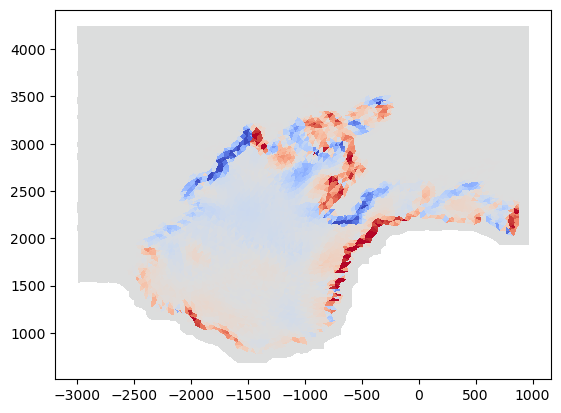

In [5]:
plt.tripcolor(tri_o, area_ratio, cmap='coolwarm', vmin=0.9, vmax=1.1)